## Data manipulation

In [78]:
import pandas as pd

In [79]:
data = pd.read_csv(r'estat_crim_off_cat.tsv', sep='\t')

In [80]:
data = data.rename({data.columns[0]: data.columns[0].replace(r"\TIME_PERIOD", "")}, axis="columns")
split_name_columns = (data.columns[0]).split(',')
count_split_columns = len(split_name_columns)
# assert?

Pokud by se dělalo zpracovávání souboru v rámci OOP, kod by neměl zahrnovat mergování 

In [81]:
data[split_name_columns] = data[data.columns[0]].str.split(',', expand=True)
data = data.drop(data.columns[0], axis="columns") #odstraneni jiz rozdeleneho sloupce

%run add_info.ipynb
data = data.merge(geo_df, how='left', on='geo')
data = data.merge(iccs_df, how='left', on='iccs')
data = data.drop(columns=['geo', 'iccs'])


In [82]:
# presun rozdelenych a naparovaných udaju  na zacatek df
reorg_columns = data.columns.tolist()
final_reorg_columns = reorg_columns[-count_split_columns:] + reorg_columns[:-count_split_columns]
data = data[final_reorg_columns]

Pokud by se dělalo zpracovávání souboru v rámci OOP, je možné, že k číslum budou přiřazeny písmena jako 'b' a 'd'. Tato data by bylo nutné dále prozkoumat, potažmo je úplně vyřadit z datasetu. 

In [83]:
data = data.replace(": ", 'NaN')

column_period = data.columns[count_split_columns:] 
data[column_period] = data[data.columns[count_split_columns:]].astype('float')

In [84]:
no_anual = data[data['freq'] != 'A'].index # podminka, ze se nejedna o rocni data
data.drop(index=no_anual, inplace=True)

no_p_hthab = data[data['unit'] != 'P_HTHAB'].index # podminka, ze se nejedna o udaj na 100tis obyvatel
data.drop(index=no_p_hthab, inplace=True)

In [85]:
years_list = data.columns[count_split_columns:]
info_list = data.columns[:count_split_columns]

In [86]:
unpivot_data = pd.melt(data, id_vars=info_list, value_vars=years_list, var_name='year', value_name='value')
unpivot_data['year'] = unpivot_data['year'].astype('int')
unpivot_data

,freq,unit,country_name,crime_info,year,value
0,A,P_HTHAB,Albania,Intentional homicide,2008,2.78
1,A,P_HTHAB,Austria,Intentional homicide,2008,0.70
2,A,P_HTHAB,Bosnia and Herzegovina,Intentional homicide,2008,1.72
3,A,P_HTHAB,Belgium,Intentional homicide,2008,1.91
4,A,P_HTHAB,Bulgaria,Intentional homicide,2008,2.29
...,...,...,...,...,...,...
11605,A,P_HTHAB,Serbia,Participation in an organized criminal group,2022,NaN
11606,A,P_HTHAB,Slovenia,Participation in an organized criminal group,2022,0.00
11607,A,P_HTHAB,Slovakia,Participation in an organized criminal group,2022,0.15
11608,A,P_HTHAB,Türkiye,Participation in an organized criminal group,2022,NaN


## Data visualisation

In [87]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
%run custom_function.ipynb # widgety nelze spoustet ze souboru .py?, pouze z ipynb, dostatz widget hodnoy je pak složitější a delší, než napsatkod přímo? - overit

In [89]:
# jedinečné názvy států a krimi činů, slouží k následnému filtrování 
country_list_sorted = sorted(list(set(unpivot_data['country_name'].tolist())))
crime_list_sorted = sorted(list(set(unpivot_data['crime_info'].tolist())))


In [71]:
country = widgets.Dropdown(
    options=country_list_sorted,
    value=country_list_sorted[0],
    description='Country:',
    disabled=False,
    )
crime = widgets.Dropdown(
    options=crime_list_sorted,
    value=crime_list_sorted[0],
    description='Crime:',
    disabled=False,
    )
display(country)
display(crime)

Dropdown(description='Country:', options=('Albania', 'Austria', 'Belgium', 'Bosnia and Herzegovina', 'Bulgaria…

Dropdown(description='Crime:', options=('Acts against computer systems', 'Attempted intentional homicide', 'Br…

In [72]:
select_country = country.value
select_crime = crime.value

unpivot_data[(unpivot_data['country_name'] == select_country) & (unpivot_data['crime_info'] == select_crime)]

,freq,unit,country_name,crime_info,year,value
585,A,P_HTHAB,Czechia,Fraud,2008,NaN
1359,A,P_HTHAB,Czechia,Fraud,2009,NaN
2133,A,P_HTHAB,Czechia,Fraud,2010,NaN
2907,A,P_HTHAB,Czechia,Fraud,2011,NaN
3681,A,P_HTHAB,Czechia,Fraud,2012,NaN
4455,A,P_HTHAB,Czechia,Fraud,2013,NaN
5229,A,P_HTHAB,Czechia,Fraud,2014,NaN
6003,A,P_HTHAB,Czechia,Fraud,2015,NaN
6777,A,P_HTHAB,Czechia,Fraud,2016,93.20
7551,A,P_HTHAB,Czechia,Fraud,2017,82.73


In [73]:
import numpy

In [ ]:
def get_info_country_crime(unpivot_data, select_country, select_crime):
    data = unpivot_data[(unpivot_data['country_name'] == select_country) & (unpivot_data['crime_info'] == select_crime)]
    value_column = data['value']

    count_years = data['year'].count()
    count_fill_values = value_column.count()
    count_unfill_values = count_years - count_fill_values
    
    mean_value = round(value_column.mean(), 2)

    max_value_row = data.loc[data['value'].idxmax()]
    min_value_row = data.loc[data['value'].idxmin()]

    max_value, max_value_year = max_value_row[['value', 'year']]
    min_value, min_value_year = min_value_row[['value', 'year']]

    min_range_year = data['year'].min()
    max_range_year = data['year'].max()

    standard_deviation = round(numpy.std(value_column), 2) #použita populační směrodatná odchylka, ddof=1 ->nastavení na výběrovou směrodatnou odchylku

    # přidat dodatečné  informace o směrodané odchylně
    # přidat info o násobku z min -> max aj
    # od jakého roku začal stát poskytovat/sbírat data - zmenit automaticky range ve widgete
    info = f'During a {count_years}-year period, {select_country} recorded {count_fill_values} entries for {select_crime} types of crime. Across these years, there were an average of {mean_value} crimes per hundred thousand inhabitants each year, but standard deviation was {standard_deviation}. The minimum recorded crime rate per hundred thousand inhabitants was {min_value} in {min_value_year}, while the maximum was {max_value} in {max_value_year}.'  

    return info, data, min_range_year, max_range_year
    


def get_info_country_allcrimes(data, select_country):
    pass

def get_info_all_crimes(data, select_crime):
    pass

def get_info_crime(unpivot_data, select_crime):
    pass

In [88]:
info, filtered_data, min_range_year, max_range_year = get_info_country_crime(unpivot_data, select_country, select_crime)
info

'During a 15-year period, Czechia recorded 7 entries for Fraud types of crime. Across these years, there were an average of 97.26 crimes per hundred thousand inhabitants each year, but standard deviation was 25.38. The minimum recorded crime rate per hundred thousand inhabitants was 74.36 in 2020, while the maximum was 153.09 in 2022.'

In [89]:
# unpivot_data[unpivot_data['country_name'] == select_country]

In [83]:
a = unpivot_data[(unpivot_data['country_name'] == select_country) & (unpivot_data['crime_info'] == select_crime)]
round(a['value'].mean(), 2)
a['value'].max()
a
max_value_row = a.loc[a['value'].idxmax()]
# max_year, max_value = max_value_row[['year', 'value']]
# x_std = numpy.std(a['value'])
# a.describe()
max_value_row
a

,freq,unit,country_name,crime_info,year,value
585,A,P_HTHAB,Czechia,Fraud,2008,NaN
1359,A,P_HTHAB,Czechia,Fraud,2009,NaN
2133,A,P_HTHAB,Czechia,Fraud,2010,NaN
2907,A,P_HTHAB,Czechia,Fraud,2011,NaN
3681,A,P_HTHAB,Czechia,Fraud,2012,NaN
4455,A,P_HTHAB,Czechia,Fraud,2013,NaN
5229,A,P_HTHAB,Czechia,Fraud,2014,NaN
6003,A,P_HTHAB,Czechia,Fraud,2015,NaN
6777,A,P_HTHAB,Czechia,Fraud,2016,93.20
7551,A,P_HTHAB,Czechia,Fraud,2017,82.73


In [81]:
# crime_all = unpivot_data[unpivot_data['crime_info'] == 'Rape']
# crime_all

In [28]:
# TODO: propojit widgetu s grafem, aby byl rovnou interaktivní, pozor na dublo, trublo grafů

In [90]:
years_range = widgets.IntRangeSlider(
    value=[min_range_year, max_range_year],
    min=min_range_year,
    max=max_range_year,
    step=1,
    description='Years:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,   
    readout_format='d',

)
years_range

IntRangeSlider(value=(2008, 2022), continuous_update=False, description='Years:', max=2022, min=2008)

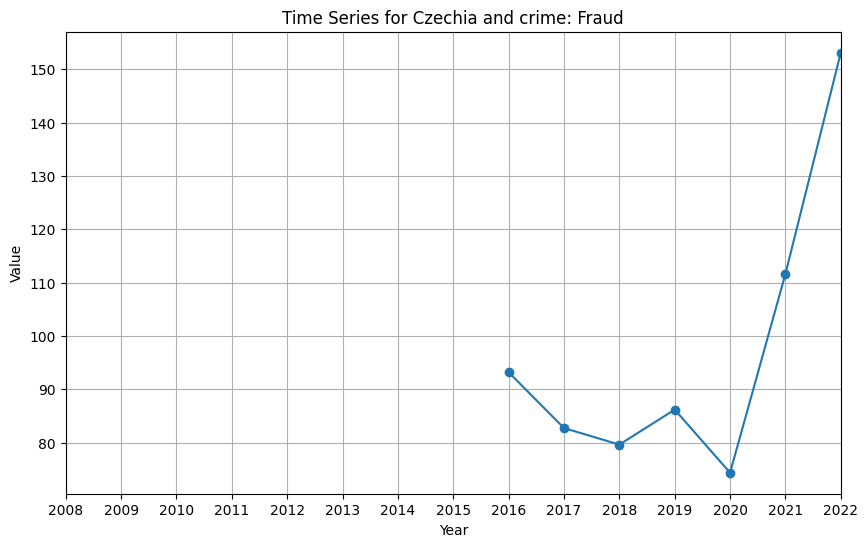

In [91]:
start_year, end_year = years_range.value
plt.figure(figsize=(10, 6))
plt.plot(filtered_data['year'], filtered_data['value'], marker='o')
plt.title(f"Time Series for {country.value} and crime: {crime.value}")
plt.xlabel("Year")
plt.ylabel("Value")
plt.grid(True)
plt.xlim(start_year, end_year)
plt.xticks(range(start_year, end_year + 1, 1))
plt.show()

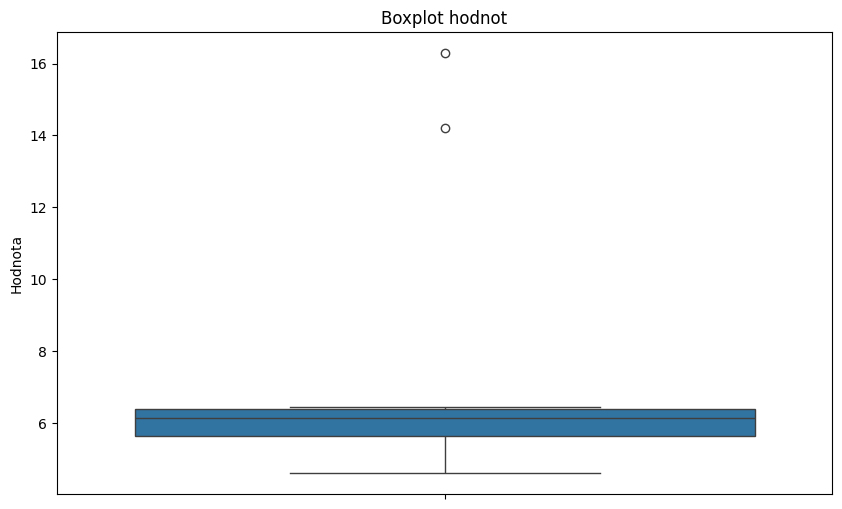

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Předpokládejme, že filtered_data je již definováno jako DataFrame
# Příklad: filtered_data = pd.DataFrame({'value': [1.5, 2.3, 2.5, 3.7, 4.1, ...]})

# Vytvoření boxplotu pro 'value'
plt.figure(figsize=(10, 6))
sns.boxplot(y='value', data=filtered_data)

# Přidání názvů a popisků
plt.title('Boxplot hodnot')
plt.ylabel('Hodnota')

# Zobrazení grafu
plt.show()

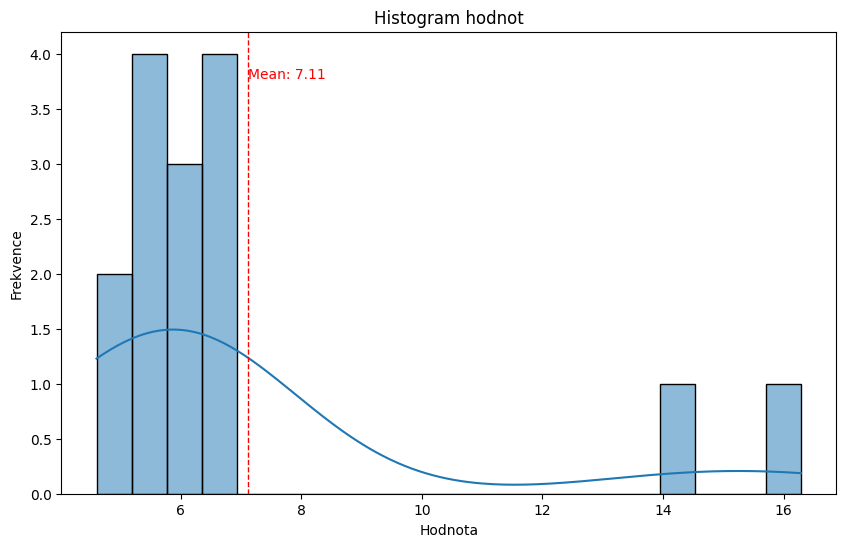

In [42]:
mean_value = round(filtered_data['value'].mean(), 2)

# Vytvoření histogramu pro 'value'
plt.figure(figsize=(10, 6))
sns.histplot(filtered_data['value'], bins=20, kde=True)

# Přidání názvů a popisků
plt.title('Histogram hodnot')
plt.xlabel('Hodnota')
plt.ylabel('Frekvence')
plt.axvline(mean_value, color = 'red', linestyle='dashed', linewidth=1)
plt.text(mean_value, plt.ylim()[1]*0.9, f'Mean: {mean_value:.2f}', color = 'red')

# Zobrazení grafu
plt.show()